SGD : stochastic gradient descent (確率的勾配降下法）

# 6.1.2 SGD

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

SDGの欠点を改善する3つの手法: Momentum, AdaGrad, Adam

# 6.1.4 Momentum

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

# 6.1.5 AdaGrad

In [4]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

# 6.1.6 Adam

In [5]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

# 6.1.8 MINISTデータセットによる更新手法の比較

In [6]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))




===========iteration:0===========
SGD:2.3428266839399017
Momentum:2.368829768522764
AdaGrad:2.8154431199075023
Adam:2.0989117657390493
===========iteration:100===========
SGD:1.6852320941643615
Momentum:0.46363110026785764
AdaGrad:0.26236869927258305
Adam:0.32629009288720917
===========iteration:200===========
SGD:0.9343630777297408
Momentum:0.2689863034201475
AdaGrad:0.1462896308515834
Adam:0.21845592463063565
===========iteration:300===========
SGD:0.6507678582013962
Momentum:0.18825002861860407
AdaGrad:0.09054218591675182
Adam:0.12166594653865076
===========iteration:400===========
SGD:0.5933063954505691
Momentum:0.3748924031418359
AdaGrad:0.2590303960305607
Adam:0.3355923324821335
===========iteration:500===========
SGD:0.4171998063595262
Momentum:0.09197549711685427
AdaGrad:0.06057122197431396
Adam:0.05639237576987054
===========iteration:600===========
SGD:0.4238085820102393
Momentum:0.15222630882422117
AdaGrad:0.05495952066503275
Adam:0.08776210851513443
===========iteration:700

<Figure size 640x480 with 1 Axes>

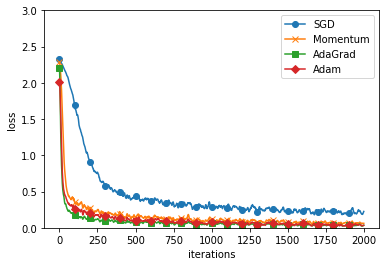

In [8]:
# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 3)
plt.legend()
plt.show()

# 6.2.2 隠れ層のアクティべーション分布

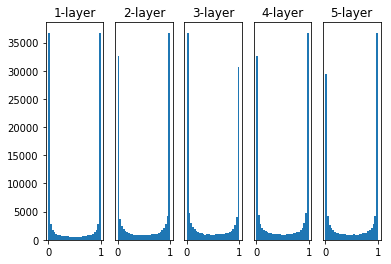

In [9]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

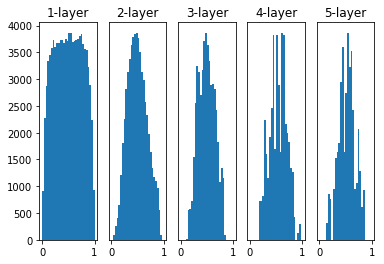

In [12]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
#     w = np.random.randn(node_num, node_num) * 1
#     w = np.random.randn(node_num, node_num) * 0.01
#     w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

In [13]:
np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

array([[-0.08483965,  0.10771089,  0.17057097, ..., -0.02662492,
        -0.08493634,  0.07094927],
       [-0.14980867,  0.2249793 ,  0.15522326, ...,  0.01077817,
         0.21139633,  0.11740865],
       [-0.0728353 ,  0.07217128, -0.15268451, ..., -0.17909849,
         0.1353933 , -0.14828442],
       ...,
       [-0.09462514, -0.18075056,  0.02512034, ..., -0.01049004,
        -0.21240569,  0.19140363],
       [ 0.06809312, -0.26305038, -0.02629252, ..., -0.10742825,
        -0.1142101 , -0.0093187 ],
       [-0.04385004,  0.03459371,  0.02716888, ...,  0.02638485,
         0.20578333,  0.19425593]])

In [14]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
std=0.01:2.3024980058913647
Xavier:2.3144837985205524
He:2.470863787550633
===========iteration:100===========
std=0.01:2.3025269172894274
Xavier:2.241925132729129
He:1.5528636845424522
===========iteration:200===========
std=0.01:2.3003173417147225
Xavier:2.091167205481829
He:0.7279373175458554
===========iteration:300===========
std=0.01:2.2997074391147123
Xavier:1.7964458421274956
He:0.6115013401261302
===========iteration:400===========
std=0.01:2.29889062297651
Xavier:1.3424032360957507
He:0.3797493025939572
===========iteration:500===========
std=0.01:2.3049307810178417
Xavier:0.9737516848879536
He:0.45465130328973336
===========iteration:600===========
std=0.01:2.3013510773653283
Xavier:0.6158687758282666
He:0.23861863374729028
===========iteration:700===========
std=0.01:2.3053550858578884
Xavier:0.6020063818426851
He:0.3259394710534428
===========iteration:800===========
std=0.01:2.3055866153091333
Xavier:0.545752855483922
He:0.306913686497132

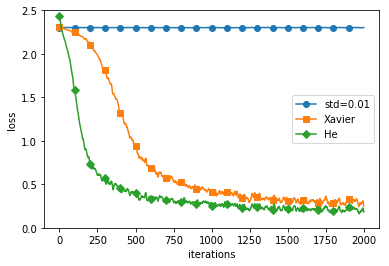

In [15]:
# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

============== 1/16 ==============
epoch:0 | 0.1 - 0.137


..\common\layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)
..\common\multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
..\common\multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.124
epoch:2 | 0.097 - 0.128
epoch:3 | 0.097 - 0.139
epoch:4 | 0.097 - 0.159
epoch:5 | 0.097 - 0.172
epoch:6 | 0.097 - 0.182
epoch:7 | 0.097 - 0.199
epoch:8 | 0.097 - 0.211
epoch:9 | 0.097 - 0.229
epoch:10 | 0.097 - 0.244
epoch:11 | 0.097 - 0.264
epoch:12 | 0.097 - 0.287
epoch:13 | 0.097 - 0.304
epoch:14 | 0.097 - 0.313
epoch:15 | 0.097 - 0.325
epoch:16 | 0.097 - 0.328
epoch:17 | 0.097 - 0.342
epoch:18 | 0.097 - 0.357


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.374
============== 2/16 ==============
epoch:0 | 0.121 - 0.114
epoch:1 | 0.097 - 0.123
epoch:2 | 0.097 - 0.124
epoch:3 | 0.097 - 0.138
epoch:4 | 0.097 - 0.16
epoch:5 | 0.097 - 0.19
epoch:6 | 0.097 - 0.224
epoch:7 | 0.097 - 0.247
epoch:8 | 0.097 - 0.274
epoch:9 | 0.097 - 0.297
epoch:10 | 0.097 - 0.318
epoch:11 | 0.097 - 0.348
epoch:12 | 0.097 - 0.37
epoch:13 | 0.097 - 0.386
epoch:14 | 0.097 - 0.398
epoch:15 | 0.097 - 0.42
epoch:16 | 0.097 - 0.441
epoch:17 | 0.097 - 0.461
epoch:18 | 0.097 - 0.468


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.476
============== 3/16 ==============
epoch:0 | 0.129 - 0.077
epoch:1 | 0.393 - 0.088
epoch:2 | 0.528 - 0.12
epoch:3 | 0.619 - 0.166
epoch:4 | 0.7 - 0.195
epoch:5 | 0.762 - 0.24
epoch:6 | 0.793 - 0.277
epoch:7 | 0.829 - 0.304
epoch:8 | 0.869 - 0.344
epoch:9 | 0.892 - 0.381
epoch:10 | 0.91 - 0.405
epoch:11 | 0.934 - 0.425
epoch:12 | 0.94 - 0.458
epoch:13 | 0.953 - 0.482
epoch:14 | 0.966 - 0.501
epoch:15 | 0.971 - 0.523
epoch:16 | 0.976 - 0.554
epoch:17 | 0.981 - 0.575
epoch:18 | 0.983 - 0.597
epoch:19 | 0.985 - 0.611


No handles with labels found to put in legend.


============== 4/16 ==============
epoch:0 | 0.122 - 0.147
epoch:1 | 0.24 - 0.158
epoch:2 | 0.373 - 0.202
epoch:3 | 0.474 - 0.257
epoch:4 | 0.563 - 0.32
epoch:5 | 0.612 - 0.363
epoch:6 | 0.658 - 0.413
epoch:7 | 0.688 - 0.472
epoch:8 | 0.688 - 0.533
epoch:9 | 0.733 - 0.57
epoch:10 | 0.753 - 0.604
epoch:11 | 0.766 - 0.635
epoch:12 | 0.781 - 0.658
epoch:13 | 0.791 - 0.685
epoch:14 | 0.804 - 0.708
epoch:15 | 0.815 - 0.718
epoch:16 | 0.832 - 0.738
epoch:17 | 0.829 - 0.762
epoch:18 | 0.835 - 0.775


No handles with labels found to put in legend.


epoch:19 | 0.856 - 0.787
============== 5/16 ==============
epoch:0 | 0.105 - 0.093
epoch:1 | 0.106 - 0.141
epoch:2 | 0.112 - 0.298
epoch:3 | 0.115 - 0.421
epoch:4 | 0.116 - 0.511
epoch:5 | 0.116 - 0.57
epoch:6 | 0.128 - 0.639
epoch:7 | 0.141 - 0.682
epoch:8 | 0.152 - 0.727
epoch:9 | 0.156 - 0.754
epoch:10 | 0.17 - 0.785
epoch:11 | 0.178 - 0.8
epoch:12 | 0.179 - 0.819
epoch:13 | 0.179 - 0.833
epoch:14 | 0.19 - 0.842
epoch:15 | 0.19 - 0.855
epoch:16 | 0.199 - 0.866
epoch:17 | 0.196 - 0.878
epoch:18 | 0.213 - 0.88


No handles with labels found to put in legend.


epoch:19 | 0.215 - 0.891
============== 6/16 ==============
epoch:0 | 0.139 - 0.091
epoch:1 | 0.142 - 0.211
epoch:2 | 0.132 - 0.46
epoch:3 | 0.126 - 0.585
epoch:4 | 0.126 - 0.651
epoch:5 | 0.117 - 0.711
epoch:6 | 0.126 - 0.747
epoch:7 | 0.116 - 0.775
epoch:8 | 0.133 - 0.807
epoch:9 | 0.121 - 0.842
epoch:10 | 0.156 - 0.854
epoch:11 | 0.134 - 0.864
epoch:12 | 0.117 - 0.882
epoch:13 | 0.117 - 0.893
epoch:14 | 0.117 - 0.91
epoch:15 | 0.117 - 0.918
epoch:16 | 0.117 - 0.928
epoch:17 | 0.117 - 0.934
epoch:18 | 0.117 - 0.94
epoch:19 | 0.117 - 0.951

No handles with labels found to put in legend.



============== 7/16 ==============
epoch:0 | 0.105 - 0.12
epoch:1 | 0.117 - 0.36
epoch:2 | 0.117 - 0.619
epoch:3 | 0.117 - 0.698
epoch:4 | 0.117 - 0.748
epoch:5 | 0.117 - 0.778
epoch:6 | 0.116 - 0.809
epoch:7 | 0.117 - 0.839
epoch:8 | 0.117 - 0.87
epoch:9 | 0.117 - 0.9
epoch:10 | 0.117 - 0.915
epoch:11 | 0.117 - 0.943
epoch:12 | 0.117 - 0.96
epoch:13 | 0.117 - 0.964
epoch:14 | 0.117 - 0.969
epoch:15 | 0.117 - 0.977
epoch:16 | 0.117 - 0.983
epoch:17 | 0.117 - 0.985
epoch:18 | 0.117 - 0.988
epoch:19 | 0.117 - 0.991


No handles with labels found to put in legend.


============== 8/16 ==============
epoch:0 | 0.116 - 0.102
epoch:1 | 0.117 - 0.327
epoch:2 | 0.117 - 0.591
epoch:3 | 0.117 - 0.73
epoch:4 | 0.117 - 0.787
epoch:5 | 0.117 - 0.821
epoch:6 | 0.117 - 0.865
epoch:7 | 0.117 - 0.885
epoch:8 | 0.117 - 0.925
epoch:9 | 0.117 - 0.952
epoch:10 | 0.117 - 0.964
epoch:11 | 0.117 - 0.983
epoch:12 | 0.117 - 0.983
epoch:13 | 0.117 - 0.987
epoch:14 | 0.117 - 0.989
epoch:15 | 0.117 - 0.99
epoch:16 | 0.117 - 0.993
epoch:17 | 0.117 - 0.995
epoch:18 | 0.117 - 0.996
epoch:19 | 0.117 - 0.996


No handles with labels found to put in legend.


============== 9/16 ==============
epoch:0 | 0.117 - 0.058
epoch:1 | 0.116 - 0.462
epoch:2 | 0.116 - 0.686
epoch:3 | 0.116 - 0.742
epoch:4 | 0.116 - 0.82
epoch:5 | 0.116 - 0.896
epoch:6 | 0.116 - 0.949
epoch:7 | 0.116 - 0.976
epoch:8 | 0.116 - 0.989
epoch:9 | 0.116 - 0.993
epoch:10 | 0.116 - 0.997
epoch:11 | 0.116 - 0.998
epoch:12 | 0.116 - 0.997
epoch:13 | 0.116 - 0.998
epoch:14 | 0.116 - 0.999
epoch:15 | 0.116 - 0.999
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:18 | 0.116 - 1.0
epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.117 - 0.143
epoch:1 | 0.116 - 0.671
epoch:2 | 0.116 - 0.839
epoch:3 | 0.116 - 0.903
epoch:4 | 0.116 - 0.921
epoch:5 | 0.116 - 0.964
epoch:6 | 0.116 - 0.976
epoch:7 | 0.116 - 0.969
epoch:8 | 0.117 - 0.979
epoch:9 | 0.117 - 0.988
epoch:10 | 0.117 - 0.992
epoch:11 | 0.117 - 0.957
epoch:12 | 0.117 - 0.996
epoch:13 | 0.117 - 0.999
epoch:14 | 0.117 - 0.999
epoch:15 | 0.117 - 0.999
epoch:16 | 0.117 - 0.999
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0
epoch:19 | 0.117 - 0.981


No handles with labels found to put in legend.


============== 11/16 ==============
epoch:0 | 0.116 - 0.127
epoch:1 | 0.116 - 0.704
epoch:2 | 0.117 - 0.714
epoch:3 | 0.117 - 0.791
epoch:4 | 0.116 - 0.853
epoch:5 | 0.116 - 0.835
epoch:6 | 0.116 - 0.884
epoch:7 | 0.116 - 0.753
epoch:8 | 0.116 - 0.887
epoch:9 | 0.116 - 0.885
epoch:10 | 0.116 - 0.892
epoch:11 | 0.116 - 0.901
epoch:12 | 0.116 - 0.983
epoch:13 | 0.116 - 0.99
epoch:14 | 0.116 - 0.991
epoch:15 | 0.117 - 0.991
epoch:16 | 0.117 - 0.991
epoch:17 | 0.117 - 0.99
epoch:18 | 0.116 - 0.991


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.987
============== 12/16 ==============
epoch:0 | 0.093 - 0.133
epoch:1 | 0.116 - 0.559
epoch:2 | 0.116 - 0.622
epoch:3 | 0.117 - 0.631
epoch:4 | 0.117 - 0.656
epoch:5 | 0.117 - 0.655
epoch:6 | 0.117 - 0.676
epoch:7 | 0.117 - 0.604
epoch:8 | 0.117 - 0.683
epoch:9 | 0.117 - 0.686
epoch:10 | 0.117 - 0.683
epoch:11 | 0.117 - 0.691
epoch:12 | 0.117 - 0.691
epoch:13 | 0.117 - 0.693
epoch:14 | 0.117 - 0.742
epoch:15 | 0.117 - 0.696
epoch:16 | 0.117 - 0.696
epoch:17 | 0.117 - 0.706
epoch:18 | 0.117 - 0.703


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.703
============== 13/16 ==============
epoch:0 | 0.094 - 0.108
epoch:1 | 0.117 - 0.441
epoch:2 | 0.117 - 0.477
epoch:3 | 0.117 - 0.533
epoch:4 | 0.117 - 0.608
epoch:5 | 0.117 - 0.615
epoch:6 | 0.117 - 0.587
epoch:7 | 0.117 - 0.615
epoch:8 | 0.117 - 0.617
epoch:9 | 0.117 - 0.62
epoch:10 | 0.117 - 0.623
epoch:11 | 0.117 - 0.629
epoch:12 | 0.117 - 0.624
epoch:13 | 0.117 - 0.631
epoch:14 | 0.117 - 0.699
epoch:15 | 0.117 - 0.708
epoch:16 | 0.117 - 0.709
epoch:17 | 0.117 - 0.693
epoch:18 | 0.117 - 0.716
epoch:19 | 0.117 - 0.703


No handles with labels found to put in legend.


============== 14/16 ==============
epoch:0 | 0.117 - 0.116
epoch:1 | 0.116 - 0.387
epoch:2 | 0.116 - 0.486
epoch:3 | 0.116 - 0.426
epoch:4 | 0.116 - 0.517
epoch:5 | 0.116 - 0.544
epoch:6 | 0.116 - 0.57
epoch:7 | 0.117 - 0.558
epoch:8 | 0.117 - 0.578
epoch:9 | 0.117 - 0.588
epoch:10 | 0.117 - 0.594
epoch:11 | 0.117 - 0.599
epoch:12 | 0.117 - 0.608
epoch:13 | 0.117 - 0.603
epoch:14 | 0.117 - 0.606
epoch:15 | 0.117 - 0.608
epoch:16 | 0.117 - 0.601
epoch:17 | 0.117 - 0.606
epoch:18 | 0.117 - 0.609


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.613
============== 15/16 ==============
epoch:0 | 0.117 - 0.118
epoch:1 | 0.116 - 0.259
epoch:2 | 0.116 - 0.327
epoch:3 | 0.116 - 0.432
epoch:4 | 0.116 - 0.469
epoch:5 | 0.116 - 0.495
epoch:6 | 0.116 - 0.489
epoch:7 | 0.116 - 0.475
epoch:8 | 0.116 - 0.487
epoch:9 | 0.116 - 0.51
epoch:10 | 0.116 - 0.511
epoch:11 | 0.116 - 0.52
epoch:12 | 0.116 - 0.505
epoch:13 | 0.116 - 0.507
epoch:14 | 0.116 - 0.494
epoch:15 | 0.116 - 0.519
epoch:16 | 0.116 - 0.612
epoch:17 | 0.116 - 0.617


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.593
epoch:19 | 0.116 - 0.617
============== 16/16 ==============
epoch:0 | 0.105 - 0.106
epoch:1 | 0.116 - 0.247
epoch:2 | 0.116 - 0.305
epoch:3 | 0.116 - 0.308
epoch:4 | 0.116 - 0.322
epoch:5 | 0.116 - 0.334
epoch:6 | 0.116 - 0.32
epoch:7 | 0.116 - 0.413
epoch:8 | 0.116 - 0.401
epoch:9 | 0.116 - 0.415
epoch:10 | 0.116 - 0.404
epoch:11 | 0.116 - 0.421
epoch:12 | 0.116 - 0.408
epoch:13 | 0.116 - 0.424
epoch:14 | 0.116 - 0.42
epoch:15 | 0.116 - 0.422
epoch:16 | 0.116 - 0.423
epoch:17 | 0.116 - 0.425
epoch:18 | 0.116 - 0.42
epoch:19 | 0.116 - 0.42


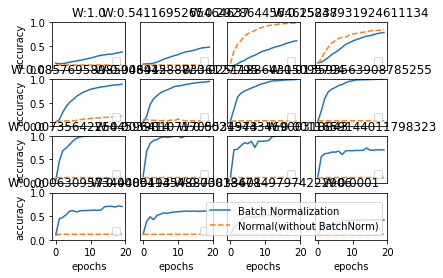

In [16]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


============== 1/16 ==============
epoch:0 | 0.093 - 0.054


..\common\multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
..\common\multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\katsunari.murase\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
..\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
..\common\layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


epoch:1 | 0.097 - 0.079
epoch:2 | 0.097 - 0.122
epoch:3 | 0.097 - 0.131
epoch:4 | 0.097 - 0.14
epoch:5 | 0.097 - 0.163
epoch:6 | 0.097 - 0.183
epoch:7 | 0.097 - 0.217
epoch:8 | 0.097 - 0.239
epoch:9 | 0.097 - 0.254
epoch:10 | 0.097 - 0.277
epoch:11 | 0.097 - 0.302
epoch:12 | 0.097 - 0.321
epoch:13 | 0.097 - 0.329
epoch:14 | 0.097 - 0.355
epoch:15 | 0.097 - 0.364
epoch:16 | 0.097 - 0.376
epoch:17 | 0.097 - 0.395
epoch:18 | 0.097 - 0.403


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.414
============== 2/16 ==============
epoch:0 | 0.093 - 0.111
epoch:1 | 0.097 - 0.119
epoch:2 | 0.097 - 0.122
epoch:3 | 0.097 - 0.116
epoch:4 | 0.097 - 0.148
epoch:5 | 0.097 - 0.161
epoch:6 | 0.097 - 0.177
epoch:7 | 0.097 - 0.189
epoch:8 | 0.097 - 0.226
epoch:9 | 0.097 - 0.237
epoch:10 | 0.097 - 0.258
epoch:11 | 0.097 - 0.28
epoch:12 | 0.097 - 0.302
epoch:13 | 0.097 - 0.324
epoch:14 | 0.097 - 0.345
epoch:15 | 0.097 - 0.365
epoch:16 | 0.097 - 0.398
epoch:17 | 0.097 - 0.414


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.437
epoch:19 | 0.097 - 0.45
============== 3/16 ==============
epoch:0 | 0.158 - 0.089
epoch:1 | 0.36 - 0.104
epoch:2 | 0.509 - 0.122
epoch:3 | 0.598 - 0.179
epoch:4 | 0.653 - 0.244
epoch:5 | 0.713 - 0.29
epoch:6 | 0.745 - 0.34
epoch:7 | 0.779 - 0.37
epoch:8 | 0.83 - 0.423
epoch:9 | 0.854 - 0.449
epoch:10 | 0.884 - 0.47
epoch:11 | 0.901 - 0.486
epoch:12 | 0.921 - 0.52
epoch:13 | 0.927 - 0.536
epoch:14 | 0.937 - 0.553
epoch:15 | 0.943 - 0.574
epoch:16 | 0.954 - 0.596
epoch:17 | 0.964 - 0.611


No handles with labels found to put in legend.


epoch:18 | 0.97 - 0.628
epoch:19 | 0.977 - 0.647
============== 4/16 ==============
epoch:0 | 0.112 - 0.091
epoch:1 | 0.332 - 0.115
epoch:2 | 0.465 - 0.202
epoch:3 | 0.548 - 0.295
epoch:4 | 0.612 - 0.349
epoch:5 | 0.672 - 0.412
epoch:6 | 0.703 - 0.462
epoch:7 | 0.74 - 0.517
epoch:8 | 0.751 - 0.555
epoch:9 | 0.781 - 0.591
epoch:10 | 0.77 - 0.625
epoch:11 | 0.795 - 0.654
epoch:12 | 0.809 - 0.673
epoch:13 | 0.822 - 0.698
epoch:14 | 0.826 - 0.715
epoch:15 | 0.85 - 0.732
epoch:16 | 0.852 - 0.746
epoch:17 | 0.853 - 0.756


No handles with labels found to put in legend.


epoch:18 | 0.855 - 0.773
epoch:19 | 0.867 - 0.779
============== 5/16 ==============
epoch:0 | 0.104 - 0.127
epoch:1 | 0.117 - 0.187
epoch:2 | 0.118 - 0.346
epoch:3 | 0.134 - 0.464
epoch:4 | 0.139 - 0.534
epoch:5 | 0.141 - 0.6
epoch:6 | 0.14 - 0.646
epoch:7 | 0.15 - 0.698
epoch:8 | 0.164 - 0.716
epoch:9 | 0.168 - 0.74
epoch:10 | 0.175 - 0.766
epoch:11 | 0.189 - 0.786
epoch:12 | 0.195 - 0.805
epoch:13 | 0.207 - 0.827
epoch:14 | 0.22 - 0.839
epoch:15 | 0.226 - 0.851
epoch:16 | 0.242 - 0.86
epoch:17 | 0.263 - 0.868
epoch:18 | 0.269 - 0.877


No handles with labels found to put in legend.


epoch:19 | 0.279 - 0.888
============== 6/16 ==============
epoch:0 | 0.131 - 0.121
epoch:1 | 0.119 - 0.195
epoch:2 | 0.13 - 0.425
epoch:3 | 0.119 - 0.592
epoch:4 | 0.116 - 0.684
epoch:5 | 0.116 - 0.736
epoch:6 | 0.116 - 0.757
epoch:7 | 0.116 - 0.783
epoch:8 | 0.116 - 0.806
epoch:9 | 0.116 - 0.821
epoch:10 | 0.116 - 0.855
epoch:11 | 0.116 - 0.862
epoch:12 | 0.117 - 0.878
epoch:13 | 0.118 - 0.896
epoch:14 | 0.116 - 0.909
epoch:15 | 0.116 - 0.921
epoch:16 | 0.116 - 0.929
epoch:17 | 0.118 - 0.939
epoch:18 | 0.136 - 0.948
epoch:19 | 0.165 - 0.955

No handles with labels found to put in legend.



============== 7/16 ==============
epoch:0 | 0.098 - 0.116
epoch:1 | 0.116 - 0.166
epoch:2 | 0.117 - 0.489
epoch:3 | 0.117 - 0.602
epoch:4 | 0.116 - 0.672
epoch:5 | 0.116 - 0.716
epoch:6 | 0.117 - 0.761
epoch:7 | 0.117 - 0.822
epoch:8 | 0.116 - 0.857
epoch:9 | 0.116 - 0.882
epoch:10 | 0.116 - 0.904
epoch:11 | 0.116 - 0.919
epoch:12 | 0.116 - 0.933
epoch:13 | 0.116 - 0.946
epoch:14 | 0.116 - 0.963
epoch:15 | 0.116 - 0.962
epoch:16 | 0.116 - 0.971
epoch:17 | 0.116 - 0.977


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.978
epoch:19 | 0.116 - 0.984
============== 8/16 ==============
epoch:0 | 0.095 - 0.105
epoch:1 | 0.117 - 0.376
epoch:2 | 0.117 - 0.671
epoch:3 | 0.117 - 0.796
epoch:4 | 0.117 - 0.839
epoch:5 | 0.117 - 0.866
epoch:6 | 0.117 - 0.886
epoch:7 | 0.117 - 0.913
epoch:8 | 0.117 - 0.924
epoch:9 | 0.117 - 0.951
epoch:10 | 0.117 - 0.972
epoch:11 | 0.117 - 0.98
epoch:12 | 0.117 - 0.987
epoch:13 | 0.117 - 0.99
epoch:14 | 0.117 - 0.993
epoch:15 | 0.117 - 0.997
epoch:16 | 0.117 - 0.996
epoch:17 | 0.117 - 0.998
epoch:18 | 0.117 - 0.998
epoch:19 | 0.117 - 0.998


No handles with labels found to put in legend.


============== 9/16 ==============
epoch:0 | 0.094 - 0.179
epoch:1 | 0.117 - 0.502
epoch:2 | 0.117 - 0.724
epoch:3 | 0.117 - 0.833
epoch:4 | 0.117 - 0.922
epoch:5 | 0.116 - 0.949
epoch:6 | 0.117 - 0.97
epoch:7 | 0.117 - 0.976
epoch:8 | 0.117 - 0.987
epoch:9 | 0.117 - 0.99
epoch:10 | 0.117 - 0.992
epoch:11 | 0.117 - 0.993
epoch:12 | 0.117 - 0.996
epoch:13 | 0.117 - 0.996
epoch:14 | 0.117 - 0.997
epoch:15 | 0.117 - 0.997
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.998
epoch:19 | 0.117 - 0.999


No handles with labels found to put in legend.


============== 10/16 ==============
epoch:0 | 0.117 - 0.158
epoch:1 | 0.117 - 0.585
epoch:2 | 0.117 - 0.727
epoch:3 | 0.117 - 0.759
epoch:4 | 0.117 - 0.84
epoch:5 | 0.117 - 0.937
epoch:6 | 0.117 - 0.94
epoch:7 | 0.117 - 0.962
epoch:8 | 0.117 - 0.984
epoch:9 | 0.117 - 0.987
epoch:10 | 0.117 - 0.984
epoch:11 | 0.117 - 0.993
epoch:12 | 0.117 - 0.995
epoch:13 | 0.117 - 0.993
epoch:14 | 0.117 - 0.997
epoch:15 | 0.117 - 0.998
epoch:16 | 0.117 - 0.998
epoch:17 | 0.117 - 0.998
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.117 - 0.195
epoch:1 | 0.117 - 0.425
epoch:2 | 0.117 - 0.645
epoch:3 | 0.117 - 0.773
epoch:4 | 0.117 - 0.809
epoch:5 | 0.116 - 0.85
epoch:6 | 0.117 - 0.942
epoch:7 | 0.117 - 0.951
epoch:8 | 0.117 - 0.96
epoch:9 | 0.117 - 0.96
epoch:10 | 0.117 - 0.959
epoch:11 | 0.117 - 0.938
epoch:12 | 0.117 - 0.979
epoch:13 | 0.117 - 0.987
epoch:14 | 0.117 - 0.988
epoch:15 | 0.117 - 0.991
epoch:16 | 0.117 - 0.989
epoch:17 | 0.117 - 0.937
epoch:18 | 0.117 - 0.989


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.993
============== 12/16 ==============
epoch:0 | 0.097 - 0.118
epoch:1 | 0.116 - 0.638
epoch:2 | 0.116 - 0.511
epoch:3 | 0.116 - 0.677
epoch:4 | 0.116 - 0.713
epoch:5 | 0.116 - 0.75
epoch:6 | 0.116 - 0.777
epoch:7 | 0.116 - 0.746
epoch:8 | 0.116 - 0.757
epoch:9 | 0.116 - 0.789
epoch:10 | 0.116 - 0.776
epoch:11 | 0.116 - 0.8
epoch:12 | 0.116 - 0.798
epoch:13 | 0.117 - 0.748
epoch:14 | 0.117 - 0.804
epoch:15 | 0.117 - 0.758
epoch:16 | 0.117 - 0.807
epoch:17 | 0.117 - 0.804


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.809
epoch:19 | 0.117 - 0.812
============== 13/16 ==============
epoch:0 | 0.117 - 0.093
epoch:1 | 0.116 - 0.356
epoch:2 | 0.116 - 0.586
epoch:3 | 0.116 - 0.55
epoch:4 | 0.117 - 0.645
epoch:5 | 0.117 - 0.699
epoch:6 | 0.116 - 0.73
epoch:7 | 0.116 - 0.734
epoch:8 | 0.117 - 0.781
epoch:9 | 0.117 - 0.785
epoch:10 | 0.117 - 0.781
epoch:11 | 0.117 - 0.719
epoch:12 | 0.117 - 0.792
epoch:13 | 0.117 - 0.797
epoch:14 | 0.117 - 0.799
epoch:15 | 0.117 - 0.8
epoch:16 | 0.117 - 0.799
epoch:17 | 0.117 - 0.801
epoch:18 | 0.117 - 0.801


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.8
============== 14/16 ==============
epoch:0 | 0.116 - 0.213
epoch:1 | 0.116 - 0.406
epoch:2 | 0.116 - 0.447
epoch:3 | 0.116 - 0.464
epoch:4 | 0.116 - 0.505
epoch:5 | 0.116 - 0.512
epoch:6 | 0.116 - 0.495
epoch:7 | 0.116 - 0.511
epoch:8 | 0.116 - 0.513
epoch:9 | 0.116 - 0.524
epoch:10 | 0.116 - 0.518
epoch:11 | 0.116 - 0.52
epoch:12 | 0.116 - 0.509
epoch:13 | 0.116 - 0.523
epoch:14 | 0.116 - 0.545
epoch:15 | 0.116 - 0.526
epoch:16 | 0.116 - 0.525
epoch:17 | 0.116 - 0.545
epoch:18 | 0.116 - 0.501


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.516
============== 15/16 ==============
epoch:0 | 0.105 - 0.099
epoch:1 | 0.116 - 0.299
epoch:2 | 0.117 - 0.365
epoch:3 | 0.117 - 0.388
epoch:4 | 0.116 - 0.382
epoch:5 | 0.116 - 0.407
epoch:6 | 0.117 - 0.409
epoch:7 | 0.117 - 0.408
epoch:8 | 0.117 - 0.414
epoch:9 | 0.117 - 0.413
epoch:10 | 0.117 - 0.415
epoch:11 | 0.117 - 0.416
epoch:12 | 0.117 - 0.416
epoch:13 | 0.117 - 0.417
epoch:14 | 0.117 - 0.417
epoch:15 | 0.117 - 0.417
epoch:16 | 0.117 - 0.417
epoch:17 | 0.116 - 0.417
epoch:18 | 0.116 - 0.417


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.521
============== 16/16 ==============
epoch:0 | 0.093 - 0.129
epoch:1 | 0.105 - 0.354
epoch:2 | 0.105 - 0.308
epoch:3 | 0.116 - 0.421
epoch:4 | 0.116 - 0.503
epoch:5 | 0.116 - 0.508
epoch:6 | 0.116 - 0.503
epoch:7 | 0.116 - 0.51
epoch:8 | 0.116 - 0.487
epoch:9 | 0.116 - 0.461
epoch:10 | 0.116 - 0.507
epoch:11 | 0.117 - 0.518
epoch:12 | 0.117 - 0.516
epoch:13 | 0.117 - 0.523
epoch:14 | 0.117 - 0.508
epoch:15 | 0.117 - 0.53
epoch:16 | 0.117 - 0.531
epoch:17 | 0.117 - 0.526
epoch:18 | 0.117 - 0.514
epoch:19 | 0.116 - 0.531


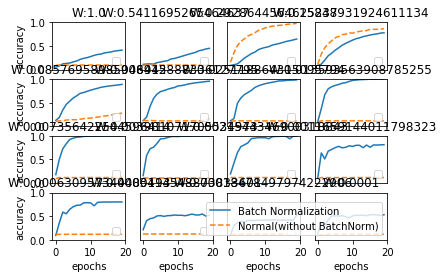

In [17]:
# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

In [ ]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.09, test acc:0.0981
epoch:1, train acc:0.09333333333333334, test acc:0.102
epoch:2, train acc:0.11, test acc:0.1068
epoch:3, train acc:0.12666666666666668, test acc:0.1151
epoch:4, train acc:0.16333333333333333, test acc:0.1264
epoch:5, train acc:0.17, test acc:0.1316
epoch:6, train acc:0.19666666666666666, test acc:0.1438
epoch:7, train acc:0.21, test acc:0.1534
epoch:8, train acc:0.23, test acc:0.1621
epoch:9, train acc:0.24, test acc:0.164
epoch:10, train acc:0.25666666666666665, test acc:0.1679
epoch:11, train acc:0.27, test acc:0.1703
epoch:12, train acc:0.29, test acc:0.179
epoch:13, train acc:0.2866666666666667, test acc:0.1784
epoch:14, train acc:0.2833333333333333, test acc:0.1811
epoch:15, train acc:0.2966666666666667, test acc:0.1883
epoch:16, train acc:0.31666666666666665, test acc:0.1991
epoch:17, train acc:0.3233333333333333, test acc:0.2101
epoch:18, train acc:0.3233333333333333, test acc:0.2139
epoch:19, train acc:0.35333333333333333, test acc:0.229

In [ ]:
# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()